##  Full Specification Data Analysis

This is a comprehensive, structured examination of the dataset, where all variables (features) are documented, explored, and understood before modeling begins.

The analysis includes:
1. **Distributional analysis** of key variables
2. **Trend and seasonality decomposition** (additive & multiplicative)
3. **Stationarity checks**, including ADF test and rolling statistics
4. **Other diagnostics**, such as correlation heatmaps and ACF/PACF inspection

These insights will inform model selection and preprocessing strategies in the next phase.

### EDA Summary: Data-Driven Reasoning Behind Analysis & Modeling

#### 1. Dataset Summary

The dataset consists of hourly time series data from March 5 to April 15, 2025, with 11,902 rows and 67 variables. Each row captures the state of the Bitcoin mempool, network activity, and market conditions at a specific hour. The target variable, `fastestFee`, estimates the minimum fee rate (in sat/vByte) required to be included in the next block. 

From our descriptive EDA, we learned the following:
- The distribution of `fastestFee` is heavily skewed with frequent spikes. This indicates volatile network behavior and motivates the need for flexible models.
- Several features (especially histogram bin counts) had extreme skewness or constant values. We removed non-informative features and log-transformed skewed distributions (e.g., fee bin counts).
- No major missing data issues were found.
- Features were grouped into four interpretable domains: **fee estimates**, **mempool state**, **block-level metrics**, and **market indicators**.

These insights helped us understand the dynamic nature of the network and guided both feature selection and modeling strategy.

#### 2. Time Series-Specific EDA
Begins in Section 7: “Trend and Seasonality”
##### Seasonal Decomposition

**Motivation:**  
To detect recurring temporal patterns (daily or weekly) in `fastestFee`, which would help determine whether models should explicitly include seasonality.

**What we learned:**  
- Strong daily seasonality exists (288 points/day in raw data, visible even in hourly form).
- Users tend to pay higher fees during daytime hours, especially on weekdays.
- Weekly signals were weaker but potentially present.

**Implication:**  
Seasonality-aware models like **HWES** or **SARIMA** may be appropriate. These patterns also influence how we engineer features for tree-based models.

##### Stationarity Check

**Motivation:**  
To determine whether the time series has a stable mean and variance over time, which is a key condition for using classical autoregressive models.

**What we learned:**  
- Rolling mean and standard deviation showed no strong trends.
- The Augmented Dickey-Fuller (ADF) test confirmed that `fastestFee` is stationary at the 5% significance level.

**Implication:**  
Since differencing is not required, we can use models like **ARIMA/SARIMA** in their standard form. Stationarity also simplifies training for models that rely on constant statistical behavior.

##### ACF / PACF Analysis

**Motivation:**  
To assess how strongly `fastestFee` depends on its past values and to determine the appropriate number of lags to use in autoregressive models or as features in machine learning models.

**What we learned:**  
- ACF showed strong autocorrelation at lag 1 and lag 2.
- PACF sharply declined after lag 2, indicating an AR(2)-like structure.

**Implication:**  
Supports the use of **ARIMA(p=2)** and justifies including `lag_1`, `lag_2`, and similar features in multivariate models like **XGBoost**.

##### Correlation Heatmaps

**Motivation:**  
To identify which external signals (e.g., mempool congestion, price shifts) are most strongly related to `fastestFee`.

**What we learned:**  
- Features like `mempool_weight`, `mempool_transactions`, and other fee recommendation metrics had high correlation with `fastestFee`.
- Market-based metrics (e.g., `price_usd_diff_1h`) showed weaker but non-negligible relationships.

**Implication:**  
These features are valuable predictors in **multivariate models**, particularly **XGBoost**, where nonlinear and interaction effects may be important.

#### 3. Modeling Rationale (Based on EDA Findings)

We selected three baseline models based on what we observed in the data:

- **ARIMA/SARIMA**:  
  Suitable because the target variable is stationary and shows short-term autocorrelation. The PACF plot indicates that an AR(2)-type model is a reasonable starting point.

- **Holt-Winters Exponential Smoothing (HWES)**:  
  Captures level, trend, and seasonality without requiring differencing. Fits well with the observed daily seasonality and smooth patterns in certain periods.

- **XGBoost**:  
  Flexible and able to model nonlinear relationships between the target and multiple external covariates. The strong correlation of mempool features and lag structure makes it well-suited to this approach.

These models reflect a data-driven modeling strategy grounded in the patterns we observed, rather than being chosen in advance.

### 1. Import Libraries & Load Dataset

We load the raw dataset containing Bitcoin mempool and blockchain metadata for downstream analysis.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_parquet('../data/raw/extracted_s3.parquet')

df.head()

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_550_600,mempool_fee_histogram_bin_600_650,mempool_fee_histogram_bin_650_700,mempool_fee_histogram_bin_700_750,mempool_fee_histogram_bin_750_800,mempool_fee_histogram_bin_800_850,mempool_fee_histogram_bin_850_900,mempool_fee_histogram_bin_900_950,mempool_fee_histogram_bin_950_1000,mempool_fee_histogram_bin_1000_plus
0,1741505382,1863701.0,997991.75,1627.0,1898161.0,1.005750,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1743132281,1713032.0,997957.25,4238.0,1955148.0,1.137755,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1741966781,1581944.0,997916.75,3786.0,6082318.0,4.827505,5.0,4.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1741739981,1995221.0,997832.00,3199.0,2070408.0,1.987956,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1741786782,1508749.0,997978.75,2663.0,2438814.0,2.007586,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(11902, 83)

### 2. Data Description
The dataset is comprised of Mar. 5 - Apr. 15, 2025 hourly time series data with 11902 rows × 67 columns (with primarily floating values). The dataset contains the following features:

![](../img/data_description.png)

### 3. Data Cleaning

To reduce dimensionality and remove irrelevant features, we dropped histogram bin columns whose values were all zero across the dataset. These columns do not provide any variance or predictive signal.

Next, we ensured that the `timestamp` column is properly converted and set as the DataFrame index. This enables correct alignment for downstream time series modeling.

In [5]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)
df = df.iloc[1:]
# df.to_parquet("../data/processed/cleaned.parquet")

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [6]:
df.shape

(11901, 67)

### 4. General Overview

#### 4.1 Dataset Summary

In [7]:
print(f"Dataset shape: {df.shape}")
df.info()
df.describe(include='all').T

Dataset shape: (11901, 67)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11901 entries, 2025-03-05 02:14:41 to 2025-04-15 09:54:42
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  11900 non-null  float64
 1   mempool_blocks_blockVSize                 11900 non-null  float64
 2   mempool_blocks_nTx                        11900 non-null  float64
 3   mempool_blocks_totalFees                  11900 non-null  float64
 4   mempool_blocks_medianFee                  11900 non-null  float64
 5   recommended_fee_fastestFee                11901 non-null  float64
 6   recommended_fee_halfHourFee               11901 non-null  float64
 7   recommended_fee_hourFee                   11901 non-null  float64
 8   recommended_fee_economyFee                11901 non-null  float64
 9   recommended_fee_minimumFee                1

,count,mean,std,min,25%,50%,75%,max
mempool_blocks_blockSize,11900.0,1.559780e+06,3.834577e+05,7501.00,1.486017e+06,1.621288e+06,1.740349e+06,3.889621e+06
mempool_blocks_blockVSize,11900.0,9.347874e+05,1.930140e+05,4367.25,9.979092e+05,9.979522e+05,9.979820e+05,9.979998e+05
mempool_blocks_nTx,11900.0,2.661760e+03,1.170631e+03,15.00,1.786750e+03,2.835500e+03,3.538250e+03,6.275000e+03
mempool_blocks_totalFees,11900.0,3.914282e+06,3.618831e+06,15658.00,1.993448e+06,3.025036e+06,4.703372e+06,8.107809e+07
mempool_blocks_medianFee,11900.0,2.630968e+00,5.128207e+00,0.00,1.191019e+00,2.007238e+00,3.014326e+00,2.731774e+02
...,...,...,...,...,...,...,...,...
mempool_fee_histogram_bin_95_100,11901.0,8.476851e+00,6.538927e+02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.083900e+04
mempool_fee_histogram_bin_100_150,11901.0,1.845300e+03,1.545902e+04,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.117370e+05
mempool_fee_histogram_bin_150_200,11901.0,1.171945e+02,2.679401e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.776300e+04
mempool_fee_histogram_bin_200_250,11901.0,1.177166e+02,2.755644e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,9.550100e+04


- All columns are of type float64 and contain no missing values.
- Many of the larger fee histogram bins contain a high proportion of zeros.
- We observed anomalies in the price_USD feature, where the minimum value is -1.
- We further investigate this issue before exploring the distribution of each feature.

#### 4.2 Anomaly Check

In [8]:
anomaly_prices = df[df['price_USD'] == -1]
anomaly_count = anomaly_prices.shape[0]
anomaly_timestamps = anomaly_prices.index 

print(f"Number of -1 values in 'price_USD': {anomaly_count}")
print(f"Timestamps (or indices) with -1 values: {anomaly_timestamps}")

Number of -1 values in 'price_USD': 4
Timestamps (or indices) with -1 values: DatetimeIndex(['2025-04-07 21:29:41', '2025-04-07 21:34:41',
               '2025-04-07 21:39:42', '2025-04-11 16:44:41'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


- Out of 11,902 rows, only 4 entries in the price_USD column have a value of -1.
- This likely indicates missing price data during those hours.
- Given the minimal impact, these rows can either be dropped or handled using simple imputation.

#### 4.3 FastestFee Time Series with Mean, Median, and 99th Percentile

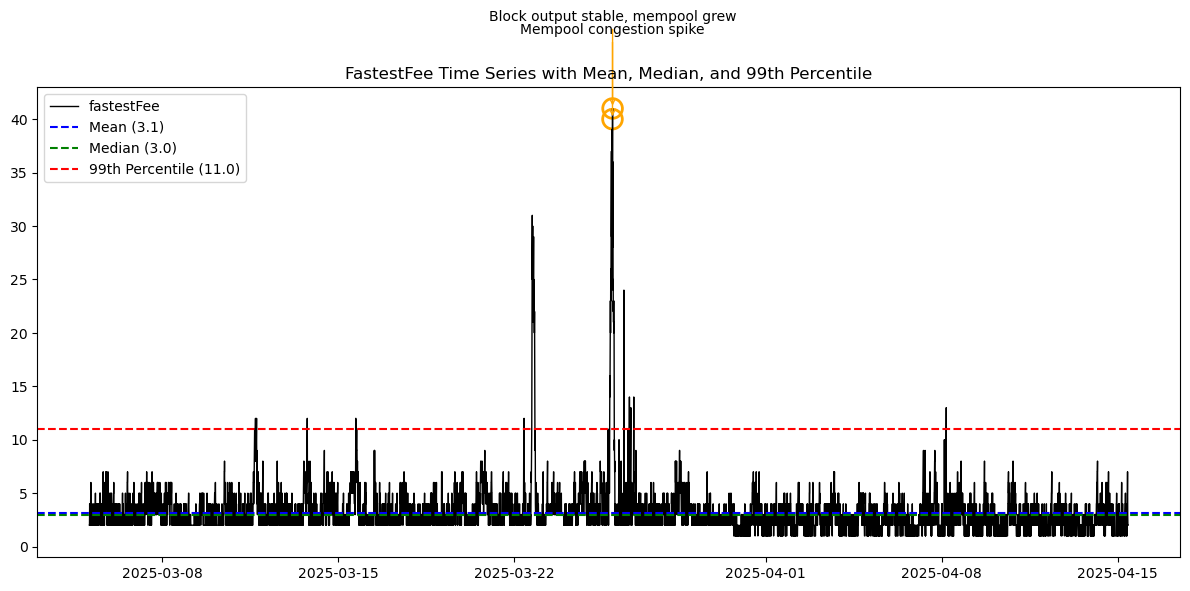

In [9]:
# 1. Extract the fastestFee series and drop any missing values
s = df['recommended_fee_fastestFee'].dropna()

# 2. Calculate summary statistics
mean_val   = s.mean()
median_val = s.median()
upper99    = s.quantile(0.99)

# 3. Identify the top 2 peak values and their timestamps
top2 = s.nlargest(2)
times = top2.index
vals  = top2.values

# 4. Create the plot
plt.figure(figsize=(12, 6))
plt.plot(s.index, s, color='black', linewidth=1, label='fastestFee')

# 5. Plot horizontal lines for mean, median, and 99th percentile
plt.axhline(mean_val,   color='blue',   linestyle='--', label=f'Mean ({mean_val:.1f})')
plt.axhline(median_val, color='green',  linestyle='--', label=f'Median ({median_val:.1f})')
plt.axhline(upper99,    color='red',    linestyle='--', label=f'99th Percentile ({upper99:.1f})')

# 6. Highlight the two highest peaks with hollow bubbles and annotate them
annotations = [
    'Block output stable, mempool grew',     # First bubble (higher spike, occurred later)
    'Mempool congestion spike'               # Second bubble (occurred earlier)
]

for (t, v), text in zip(zip(times, vals), annotations):
    plt.scatter(t, v, s=200, facecolors='none',
                edgecolors='orange', linewidths=2)
    plt.annotate(
        text,
        xy=(t, v), xytext=(t, v * 1.2),
        arrowprops=dict(arrowstyle='->', color='orange'),
        ha='center'
    )

# 7. Add title, legend, and layout
plt.title('FastestFee Time Series with Mean, Median, and 99th Percentile')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


**Insight:**  
We observed two extreme spikes in `fastestFee`. Upon investigation, both events coincided with rapid growth in mempool congestion, while block throughput remained stable.  
This suggests that the spikes were likely caused by temporary network overloads where demand outpaced supply.

### 5. Feature Description Distribution

#### 5.1 Summary Table of Key Features

| Feature                                  | Description                                            |
|:-----------------------------------------|:-------------------------------------------------------|
| mempool_blocks_blockSize                 | Total raw block size of pending transactions (bytes)   |
| mempool_blocks_blockVSize                | Virtual size of pending block (vBytes)                 |
| mempool_blocks_nTx                       | Number of transactions in the estimated next block     |
| mempool_blocks_totalFees                 | Total fees expected in next block (satoshis)           |
| mempool_blocks_medianFee                 | Median fee rate in the next block (sats/vB)            |
| recommended_fee_fastestFee               | Recommended fee for fastest confirmation (sats/vB)     |
| recommended_fee_halfHourFee              | Recommended fee for confirmation within 30 mins        |
| recommended_fee_hourFee                  | Recommended fee for confirmation within 1 hour         |
| recommended_fee_economyFee               | Recommended low-priority fee (slower confirmation)     |
| recommended_fee_minimumFee               | Minimum fee needed to enter the mempool                |
| mempool_count                            | Number of unconfirmed transactions in the mempool      |
| mempool_vsize                            | Total virtual size of mempool (vBytes)                 |
| mempool_total_fee                        | Total fee volume of mempool (sats)                     |
| difficulty_adjustment_progressPercent    | Progress toward next difficulty adjustment (%)         |
| difficulty_adjustment_difficultyChange   | Expected difficulty change (%)                         |
| difficulty_adjustment_remainingBlocks    | Blocks left until next difficulty adjustment           |
| difficulty_adjustment_remainingTime      | Estimated time until difficulty adjustment (sec)       |
| difficulty_adjustment_previousTime       | Time taken for the previous difficulty epoch (sec)     |
| difficulty_adjustment_nextRetargetHeight | Height at which next difficulty retarget occurs        |
| difficulty_adjustment_timeAvg            | Average time between blocks in the current epoch (sec) |
| difficulty_adjustment_adjustedTimeAvg    | Adjusted average block time considering skew           |
| difficulty_adjustment_timeOffset         | Time offset vs. expected block production              |
| difficulty_adjustment_expectedBlocks     | Expected blocks per difficulty period                  |
| price_USD                                | Bitcoin market price in USD                            |
| price_EUR                                | Bitcoin market price in EUR                            |
| price_GBP                                | Bitcoin market price in GBP                            |
| price_CAD                                | Bitcoin market price in CAD                            |
| price_CHF                                | Bitcoin market price in CHF                            |
| price_AUD                                | Bitcoin market price in AUD                            |
| price_JPY                                | Bitcoin market price in JPY                            |
| mempool_fee_histogram_bin_               | Each mempool_fee_histogram_bin_* feature represents the number of transactions in the mempool whose fee rate falls within a specific sats/vB range (e.g., bin_1_2 means 1–2 sats/vB).|

#### 5.2 Mempool Block Features

The mempool block features exhibit varying levels of skewness. For example, `mempool_blocks_totalFees` and `mempool_blocks_medianFee` show strong right-skewed distributions, suggesting high variability in fee values. These may benefit from log transformation in modeling.


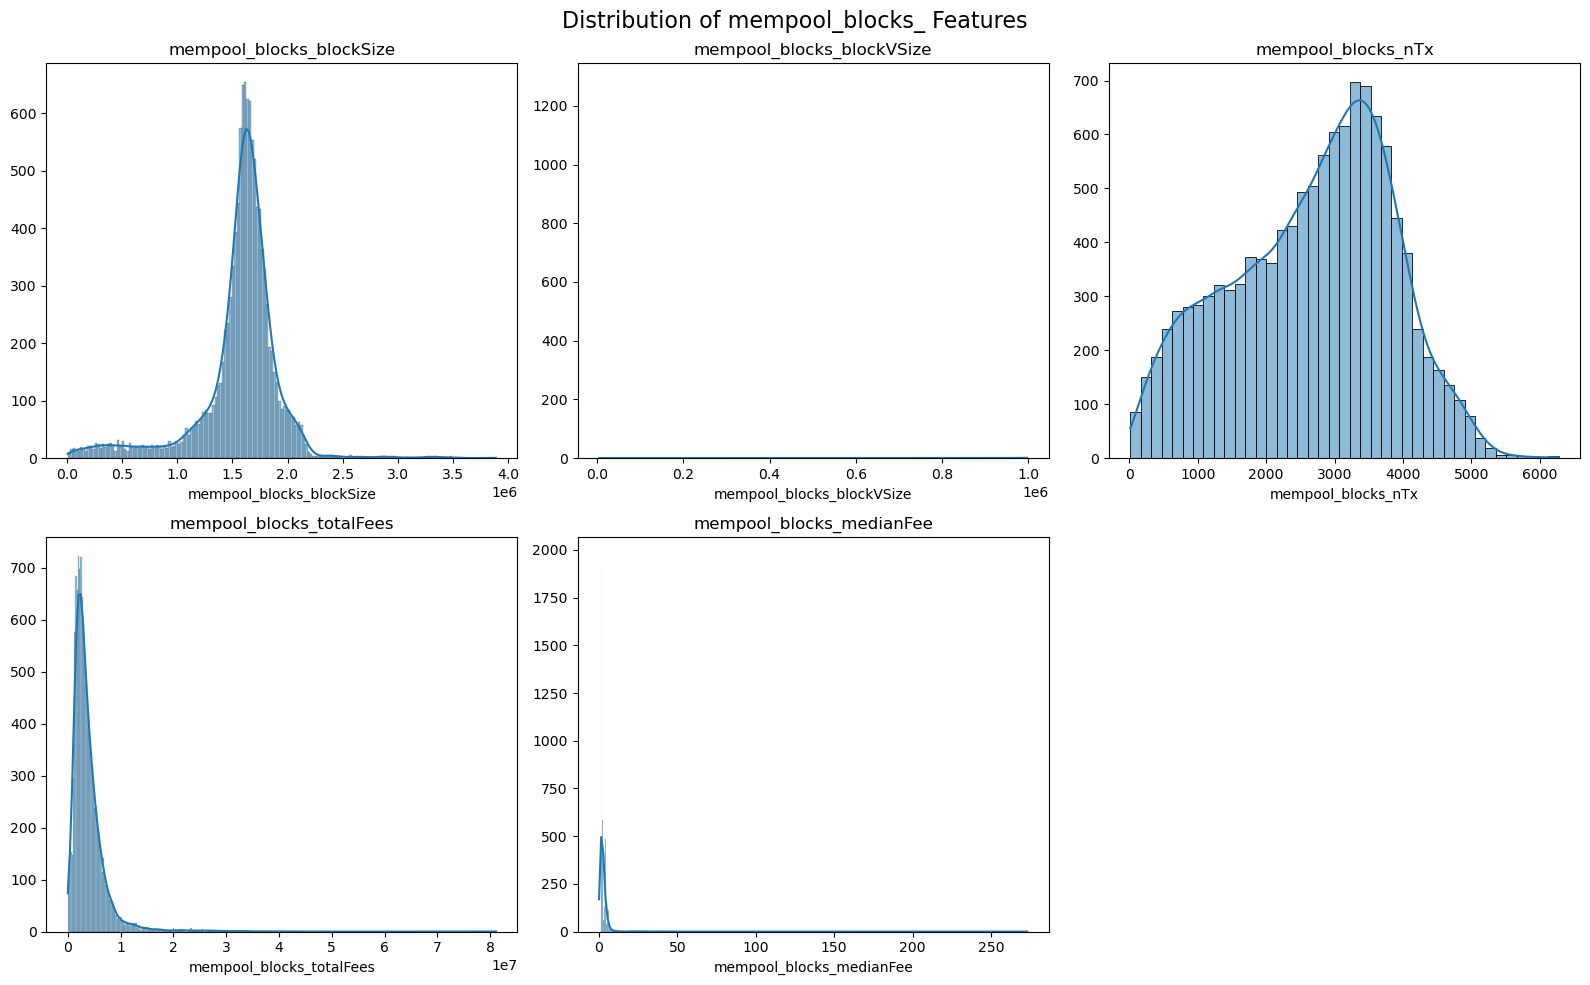

In [10]:
def plot_feature_group(df, prefix, max_cols=3, figsize=(16, 10)):
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    n = len(group_cols)
    rows = (n + max_cols - 1) // max_cols
    fig, axes = plt.subplots(rows, max_cols, figsize=figsize, squeeze=False)
    
    for i, col in enumerate(group_cols):
        ax = axes[i // max_cols][i % max_cols]
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
        ax.set_ylabel("")
    for j in range(i+1, rows * max_cols):
        fig.delaxes(axes[j // max_cols][j % max_cols])

    fig.suptitle(f"Distribution of {prefix} Features", fontsize=16)
    fig.tight_layout()
    plt.show()

plot_feature_group(df, "mempool_blocks_")


#### 5.3 Mempool State Features

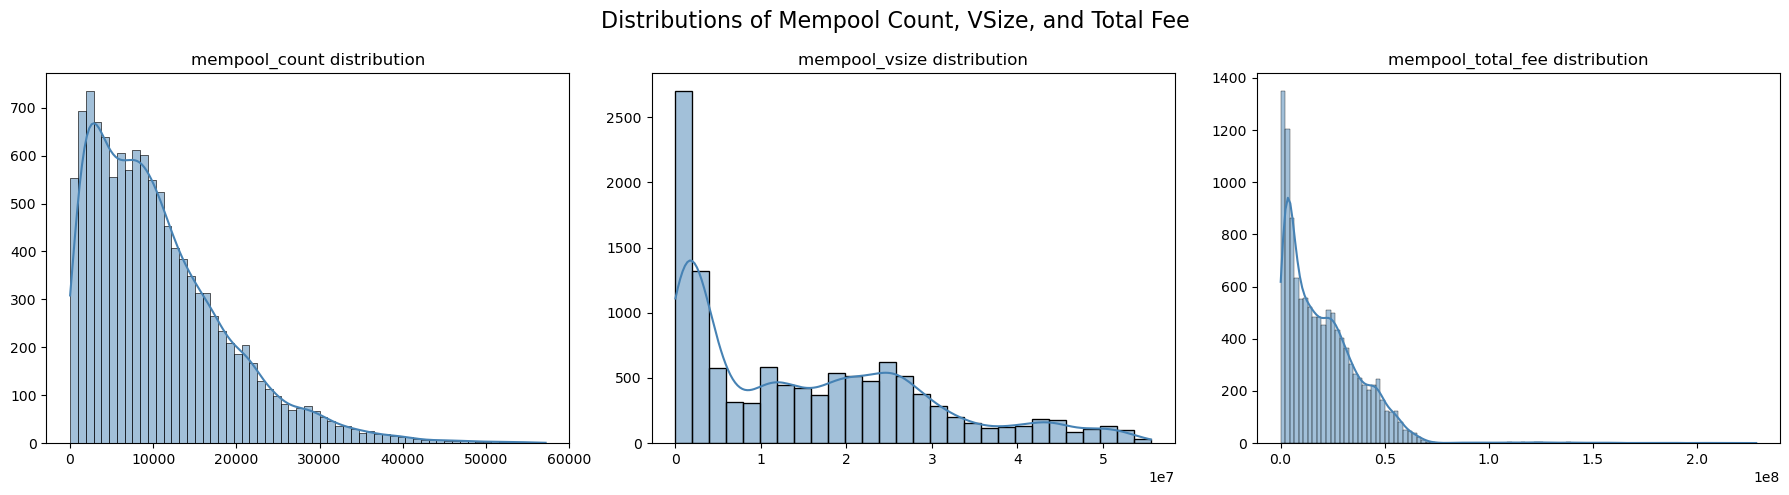

In [11]:
features = ["mempool_count", "mempool_vsize", "mempool_total_fee"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

fig.suptitle("Distributions of Mempool Count, VSize, and Total Fee", fontsize=16)
plt.tight_layout()
plt.show()

- `mempool_count`, `mempool_vsize` and `mempool_total_fee` all exhibit strong right-skewness with long tails.

- A log transformation or outlier trimming may help stabilize variance and improve model fit.


#### 5.4 Difficulty Adjustment Features

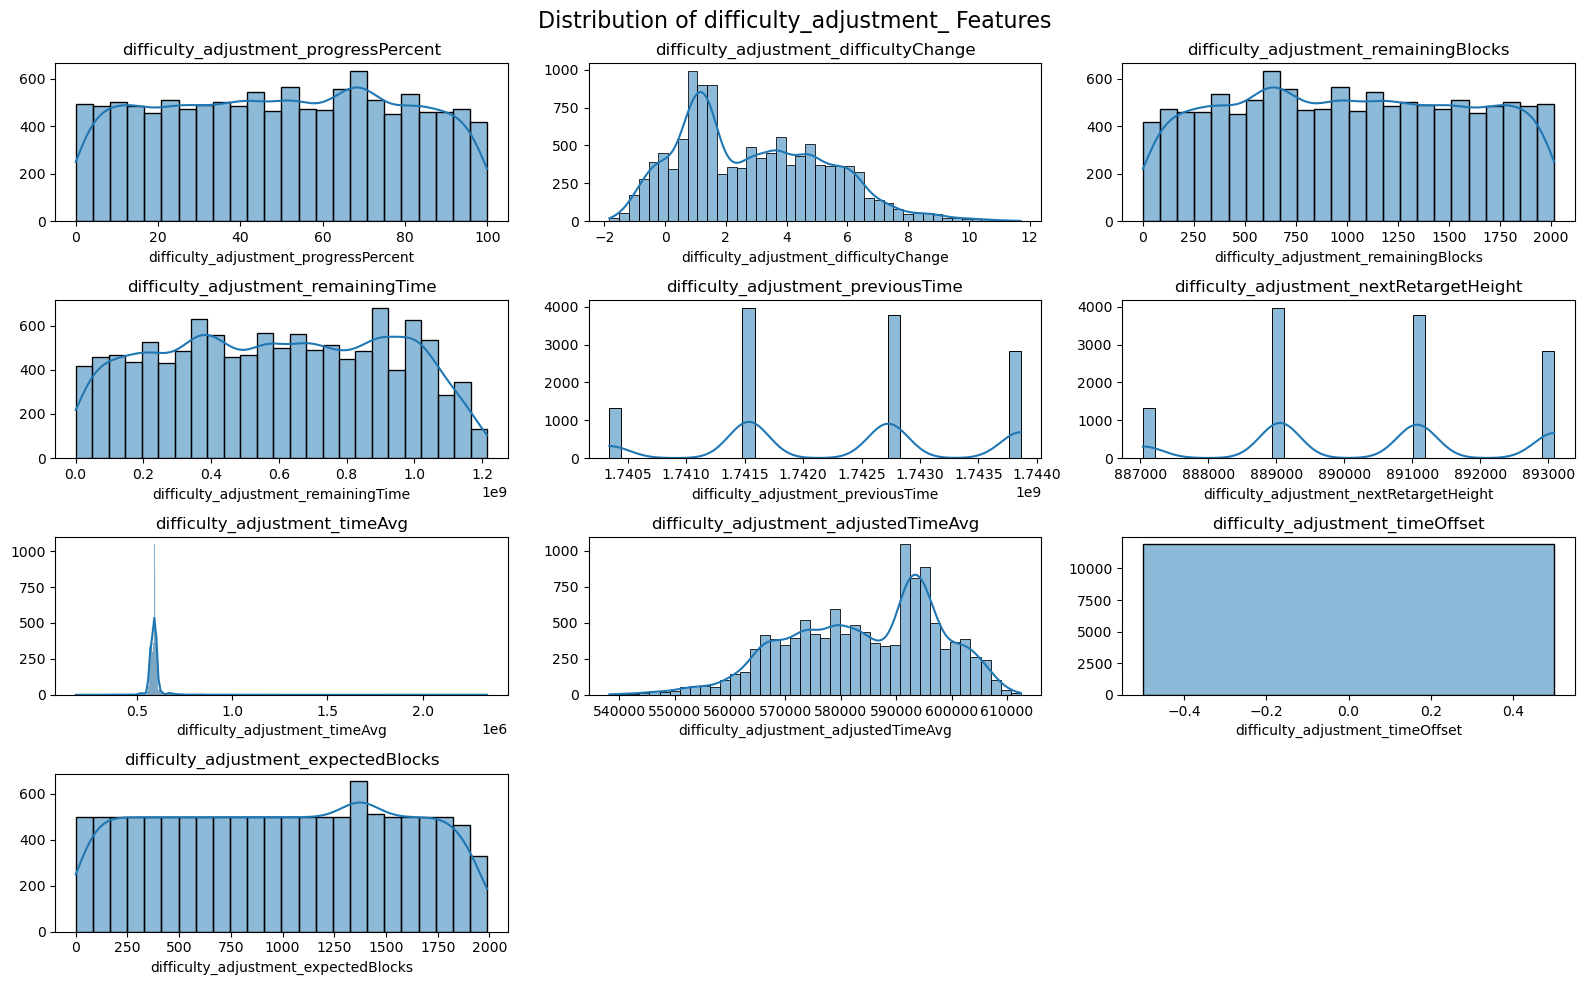

In [12]:
plot_feature_group(df, "difficulty_adjustment_")


- Features like `difficulty_adjustment_progressPercent` and `difficulty_adjustment_expectedBlocks` appear roughly uniform or multi-modal, reflecting variability across epochs.

- Discrete spikes in `previousTime` and `nextRetargetHeight` correspond to deterministic retarget boundaries—these may serve as useful epoch markers.

#### 5.5 Price Features

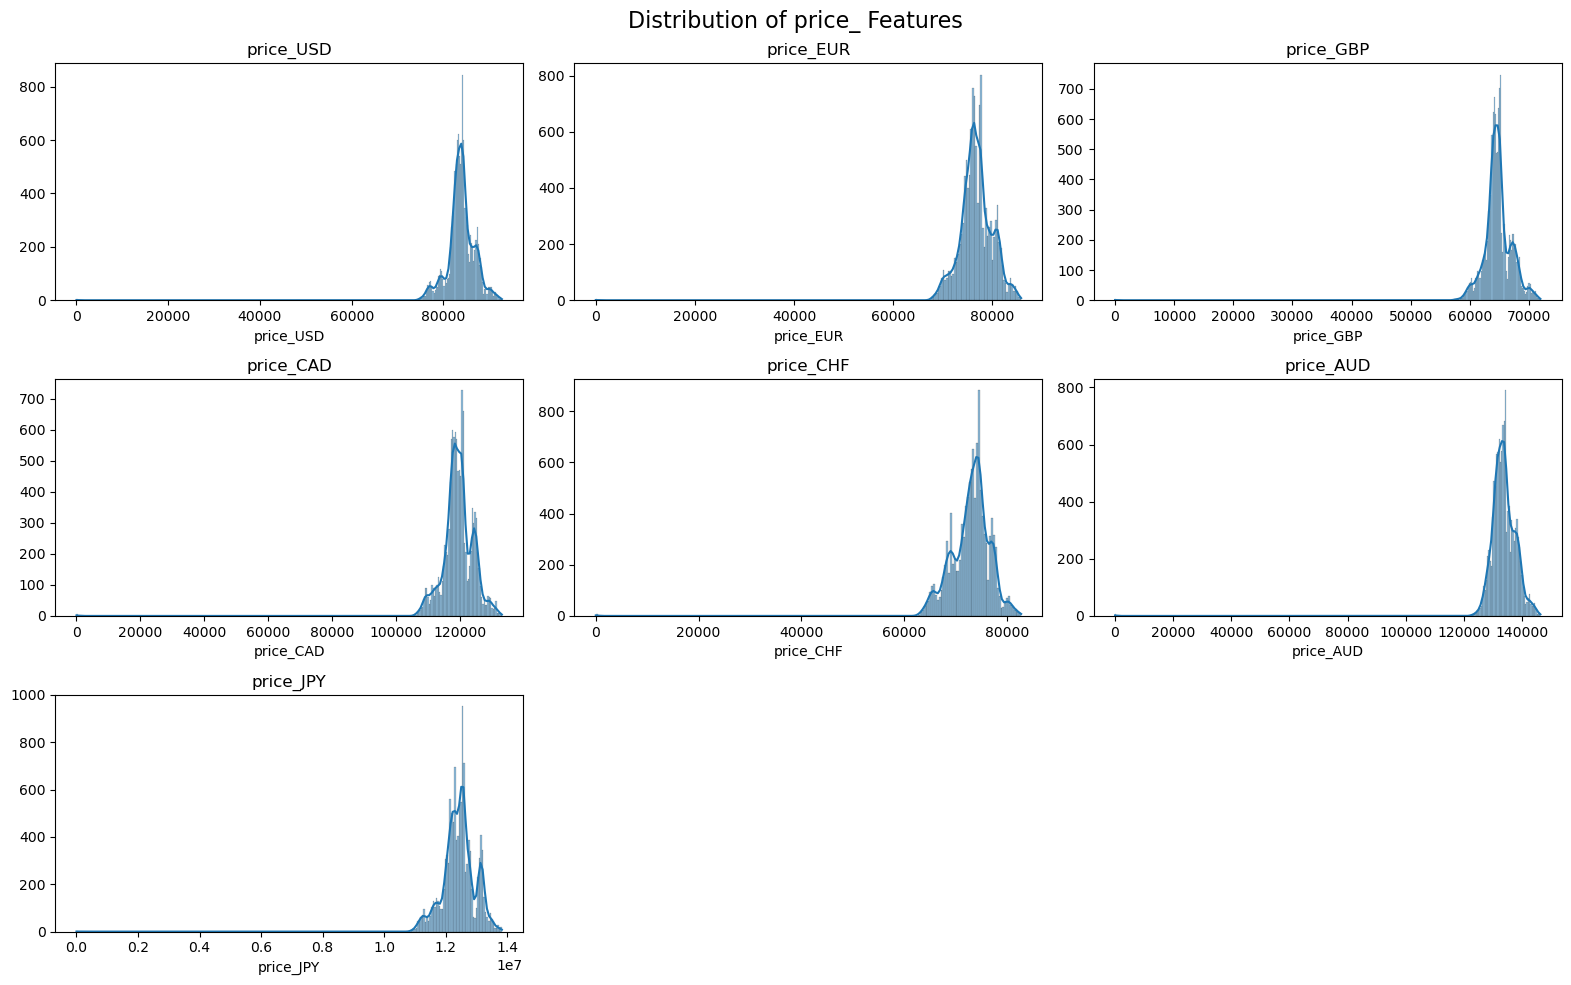

In [13]:
plot_feature_group(df, "price_")

- All currency prices (`price_USD`, `price_EUR`, …) cluster around narrow ranges with similar shapes, apart from four outlier points at –1 (handled earlier).

- Price series are relatively stable and can be treated as external covariates without additional transformation.

#### 5.6 Histogram Bin Features

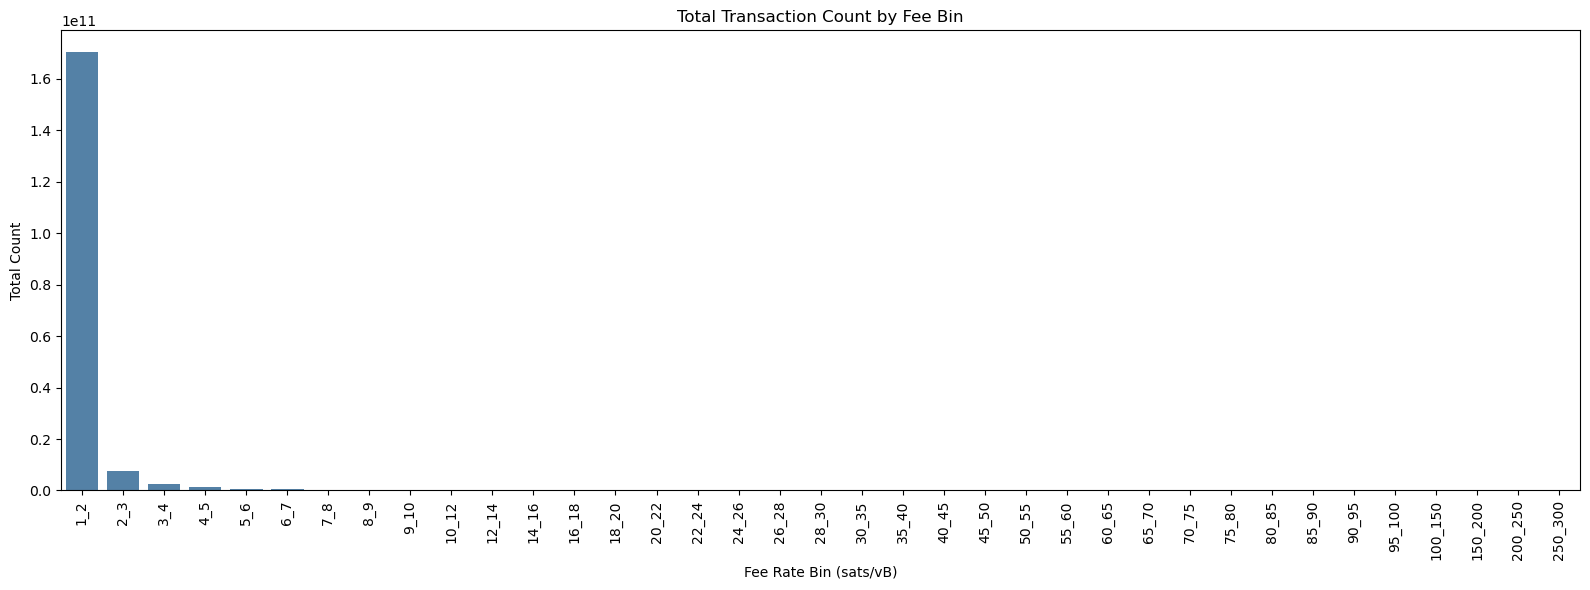

In [14]:
fee_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()
def extract_start(bin_name):
    return float(bin_name.split("_")[-2])
total_per_bin = total_per_bin.sort_values(key=lambda x: [extract_start(c) for c in x.index])
bin_labels = [col.replace("mempool_fee_histogram_bin_", "") for col in total_per_bin.index]
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=total_per_bin.values, color="steelblue")
plt.xticks(rotation=90)
plt.title("Total Transaction Count by Fee Bin")
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


- Roughly 92.5% of all transactions fall into the 1–2 sats/vB bin; including 2–3 sats/vB brings the cumulative share above 96%.

- Higher-fee bins are extremely sparse—consider merging rare bins or focusing only on the first few for modeling to reduce sparsity.

#### 5.7 Fee Bin Proportions

In [15]:
# Calculate the proportion of each bin's count relative to the total count
total_count = total_per_bin.sum()
bin_proportions = total_per_bin / total_count * 100
bin_proportions.head()

mempool_fee_histogram_bin_1_2    92.533407
mempool_fee_histogram_bin_2_3     4.155132
mempool_fee_histogram_bin_3_4     1.416449
mempool_fee_histogram_bin_4_5     0.678643
mempool_fee_histogram_bin_5_6     0.391679
dtype: float64

- Over 98% of all transactions fall into the 0–5 sats/vB range (92.5% in 1–2, 4.2% in 2–3, 1.4% in 3–4, 0.7% in 4–5 sats/vB).

- Bins above 5 sats/vB are extremely rare and could be aggregated or treated as “other” in downstream modeling to reduce sparsity.

#### 5.8 Log-Scaled Fee Bin Counts

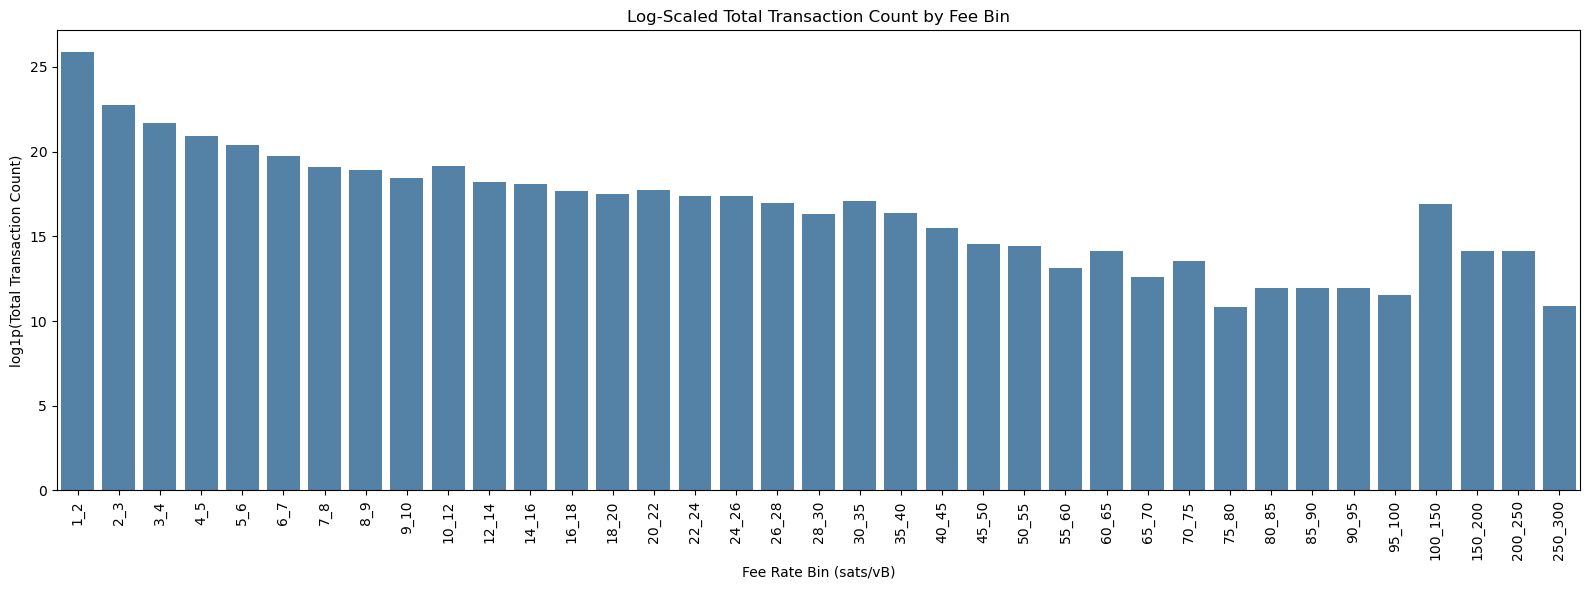

In [16]:
# Sum total transaction counts for each fee bin
fee_cols = [c for c in df.columns if c.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()

# Extract numeric labels for plotting
bin_labels = [c.replace("mempool_fee_histogram_bin_", "") for c in total_per_bin.index]

# Apply log1p transformation to counts
log_counts = np.log1p(total_per_bin)

# Plot the log-scaled counts
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=log_counts.values, color="steelblue")
plt.xticks(rotation=90)
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("log1p(Total Transaction Count)")
plt.title("Log-Scaled Total Transaction Count by Fee Bin")
plt.tight_layout()
plt.show()

After applying the log₁p transform, the dominance of the 1–2 sats/vB bin is still clear, but the decline across higher bins appears much smoother. This view highlights that, although the vast majority of transactions occur at very low fees, there is meaningful activity extending up to around 20 sats/vB rather than an immediate drop to near zero.


### 6. Timestamp Coverage & Sampling

We check the overall time coverage and sampling interval of the dataset.

In [17]:
print("Start:", df.index.min())
print("End:", df.index.max())
print("Frequency mode:", df.index.to_series().diff().mode())

Start: 2025-03-05 02:14:41
End: 2025-04-15 09:54:42
Frequency mode: 0   0 days 00:05:00
Name: timestamp, dtype: timedelta64[ns]


The most frequent sampling interval is 5 minutes, but the data is not strictly regular. Many forecasting models assume evenly spaced time steps, so we may need to reindex and interpolate the data later depending on the model's required frequency. (e.g., ARIMA, TFT, DeepAR)

### 7. Trend and Seaonality of Fastest Fee

We explore the temporal structure of the target variable `recommended_fee_fastestFee` to identify possible long-term trends and short-term seasonality patterns.

To match the model input format, we use a 5-minute resampled time series, with daily periodicity (`period=288`).

#### 7.1 Additive Decomposition of Target Feature

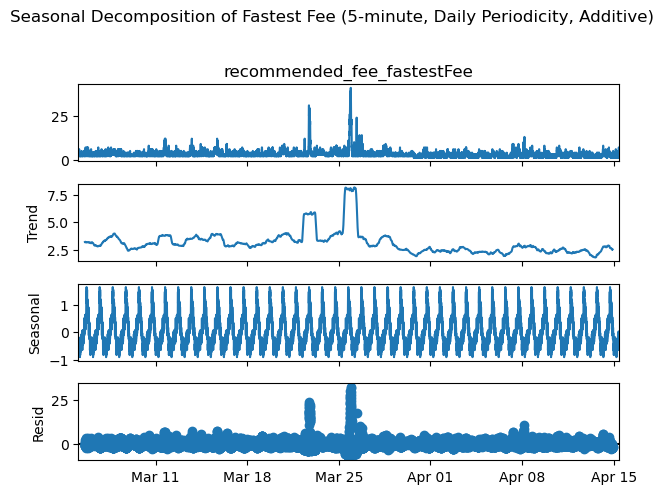

In [18]:
# Use 5-minute resampled data
# period=288 means 288 5-minute intervals = 1 day
decomp_result = seasonal_decompose(df["recommended_fee_fastestFee"], model='additive', period=288)
decomp_result.plot()
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) 
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Additive)", y=1.02)
plt.tight_layout()
plt.show()

We performed an additive decomposition on `recommended_fee_fastestFee` using a daily period (288 five-minute intervals).

- The trend component shows a gradual increase and a few prominent spikes, suggesting changing network demand over time.

- The seasonal component reveals a strong daily pattern, confirming periodicity in fee behavior.

- The residual component captures sharp local fluctuations and anomalies, particularly around March 22–25 and early April.

This result confirms that the fee rate exhibits clear trend and seasonality, and that decomposition can help isolate noise or unusual events for better forecasting.

#### 7.2 Multiplicative Decomposition of Target Feature

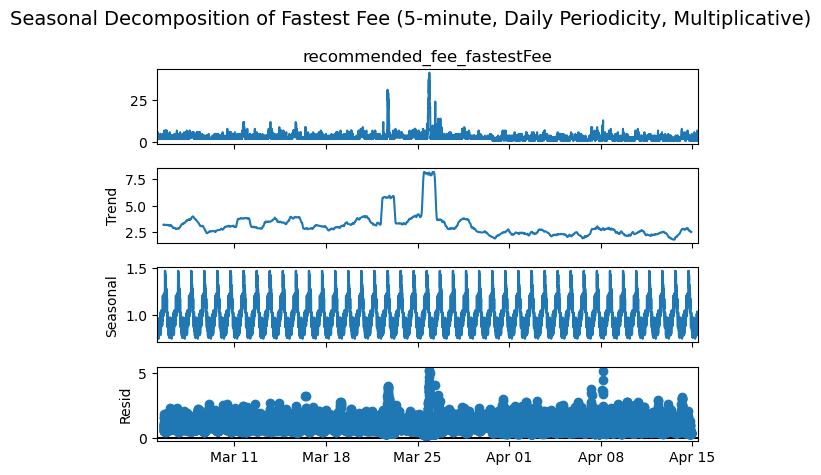

In [19]:
# Multiplicative decomposition using daily periodicity (288 intervals = 24 hours)
result_mul = seasonal_decompose(
    df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288
)

# Plot the decomposition
result_mul.plot()
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) 
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Multiplicative)", fontsize=14)
plt.tight_layout()
plt.show()

The multiplicative decomposition of `recommended_fee_fastestFee` reveals:

- A daily seasonality pattern with stable oscillations, confirming 24-hour trading cycles.
- A nonlinear trend showing a temporary fee spike in late March.
- Significant residual spikes suggest anomalous behavior or sudden congestion events not captured by seasonal or trend components.

This supports the use of time series models that account for both seasonality and event-driven outliers (e.g., Prophet, DeepAR).

#### 7.3 Residual Diagnostics

We examine whether the residual component from the multiplicative decomposition contains meaningful structure or is merely random noise.

We focus on the multiplicative version because it better captures the proportional seasonal variation observed in the original data.  
Additive residuals are not analyzed further, as multiplicative decomposition is more appropriate for our data scale and volatility patterns.

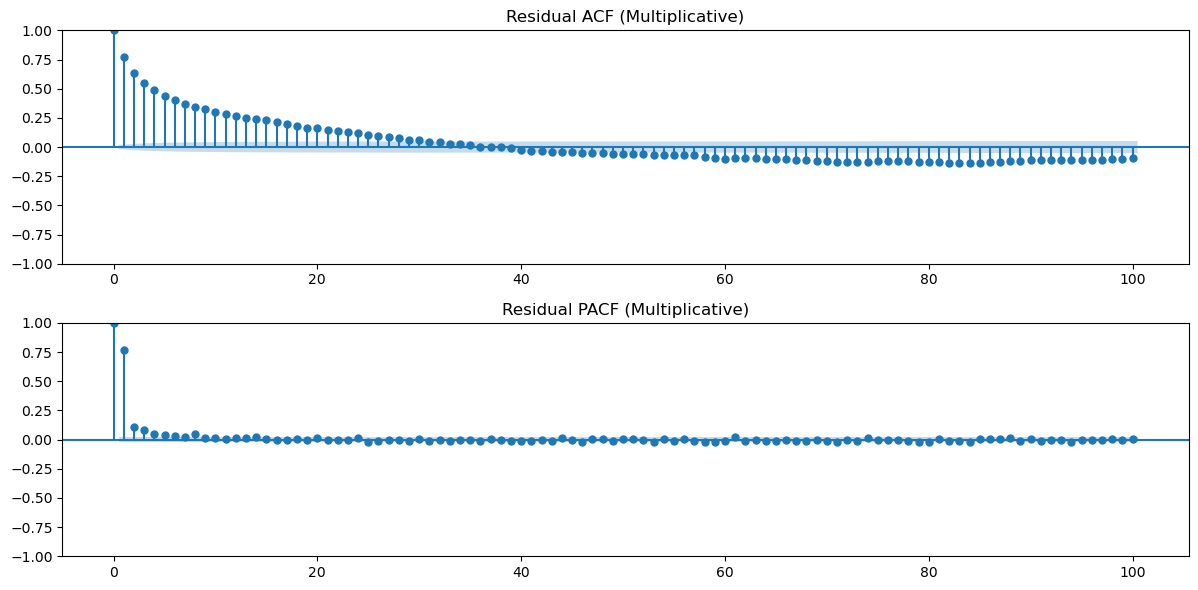

In [37]:
residuals = result_mul.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(residuals, ax=ax[0], lags=100, title='Residual ACF (Multiplicative)')
plot_pacf(residuals, ax=ax[1], lags=100, title='Residual PACF (Multiplicative)')
plt.tight_layout()
plt.show()

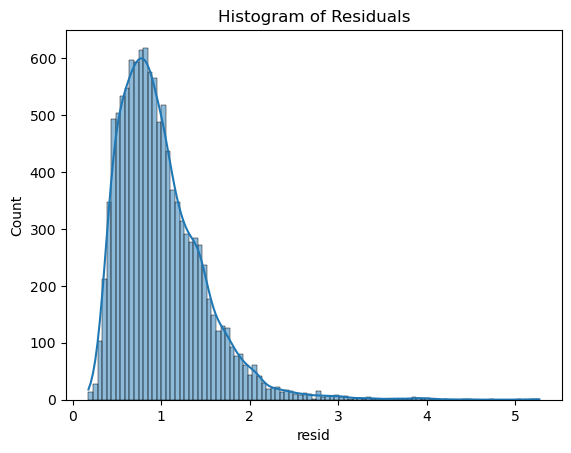

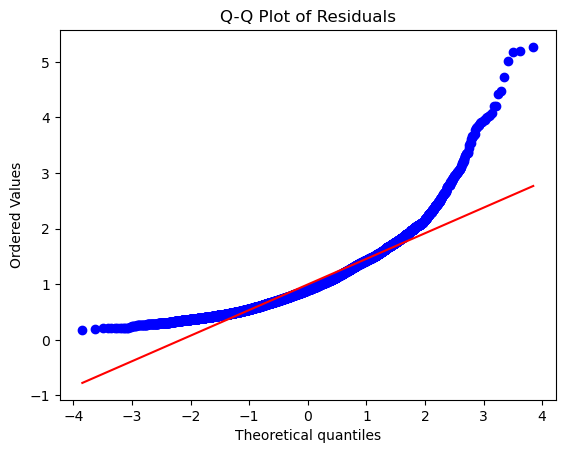

In [39]:
# Histogram
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

- **ACF and PACF plots** reveal significant autocorrelation at lag 1 and slowly decaying correlations over the first 20 lags, indicating that the residuals retain some temporal structure.
- **Histogram and Q-Q plot** show that the residuals are right-skewed and deviate from a normal distribution, especially in the tails.

These findings suggest that the residuals are not purely white noise, and may still contain useful signal.  
Therefore, further investigation—such as segmenting residuals by date or incorporating them into a hybrid modeling approach—may be warranted.

In [40]:
# Extract residuals from multiplicative decomposition
residuals = result_mul.resid.dropna().to_frame(name='resid')

# Create custom week index from timestamp
start_time = residuals.index.min()
residuals['week'] = ((residuals.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Calculate summary stats per week
resid_stats = residuals.groupby('week')['resid'].describe()[['mean', 'std', 'min', 'max']]
display(resid_stats)


,mean,std,min,max
week,,,,
1,1.010077,0.397150,0.440684,2.636894
2,0.991819,0.380096,0.397919,3.244774
3,0.985015,0.628309,0.178043,5.269792
4,1.006711,0.441582,0.319063,2.997579
5,0.990070,0.535079,0.264818,5.195491
6,0.992523,0.505876,0.292090,3.178888


We analyze the weekly distribution of residuals from the multiplicative decomposition to identify whether specific time periods exhibit greater volatility or unexplained variation.

Week **3** exhibits the highest residual variability, with both the largest standard deviation (0.63) and maximum residual value (5.27) across all weeks.  
This suggests the presence of potential modeling underfit or unexplained spikes during that period.

Week **5** also shows elevated residual spikes, though slightly less extreme than Week 3, and may warrant further attention depending on the modeling context.

Overall, these findings indicate that residual volatility is not uniformly distributed across weeks and may reflect event-driven anomalies or structural modeling gaps.

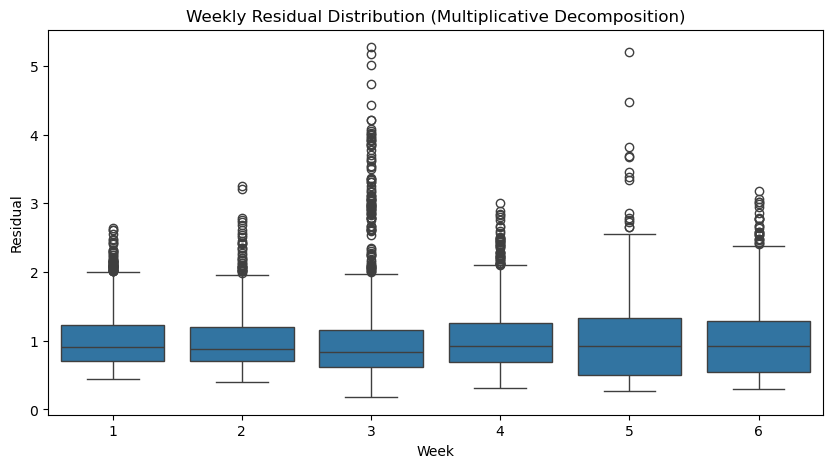

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=residuals, x='week', y='resid')
plt.title('Weekly Residual Distribution (Multiplicative Decomposition)')
plt.ylabel('Residual')
plt.xlabel('Week')
plt.show()

The boxplot confirms that **Week 3** exhibits the most extreme residual behavior, with a wider interquartile range and a high density of upper outliers.  
This aligns with our earlier statistical summary showing the highest standard deviation and maximum residual value in that week.

**Week 5** also displays elevated residual dispersion and notable outliers, suggesting additional variability or unmodeled patterns.

These residual anomalies indicate potential underfit in those specific periods and will be taken into consideration during model refinement.


#### 7.4 Weekly Seasonality Decomposition

To further explore longer-term cyclic behavior, we decomposed the fastest fee series using a 7-day seasonal period (2016 intervals based on 5-minute sampling). This allows us to inspect whether weekly patterns—such as weekday vs. weekend congestion—are present in the data.

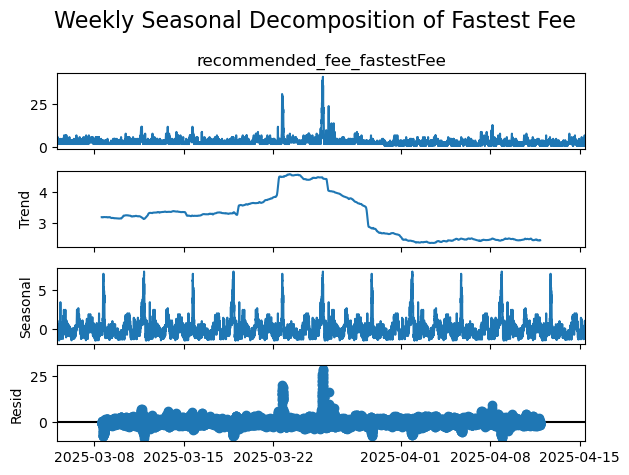

In [20]:
# Weekly decomposition (7 days = 2016 intervals for 5-minute data)
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_result = seasonal_decompose(df['recommended_fee_fastestFee'], model='additive', period=2016)
weekly_result.plot()
plt.suptitle("Weekly Seasonal Decomposition of Fastest Fee", fontsize=16)
plt.tight_layout()
plt.show()

The trend component shows a clear rise and fall pattern across the study period. The seasonal component exhibits periodic spikes roughly every 7 days, suggesting some weekly structure. 

However, the weekly effect is weaker and noisier than the daily seasonal pattern observed earlier. This implies that while some weekly behavior exists, daily cycles dominate the overall fee dynamics.

### 8. Stationarity Checks of Target Feature

We examine whether the target time series is stationary using visual and statistical methods. Stationarity is a key assumption for many time series models such as ARIMA.

#### 8.1 Rolling Mean and Standard Deviation

We plot the rolling mean and standard deviation of the target feature to visually assess stationarity. A stationary series should have relatively constant mean and variance over time.

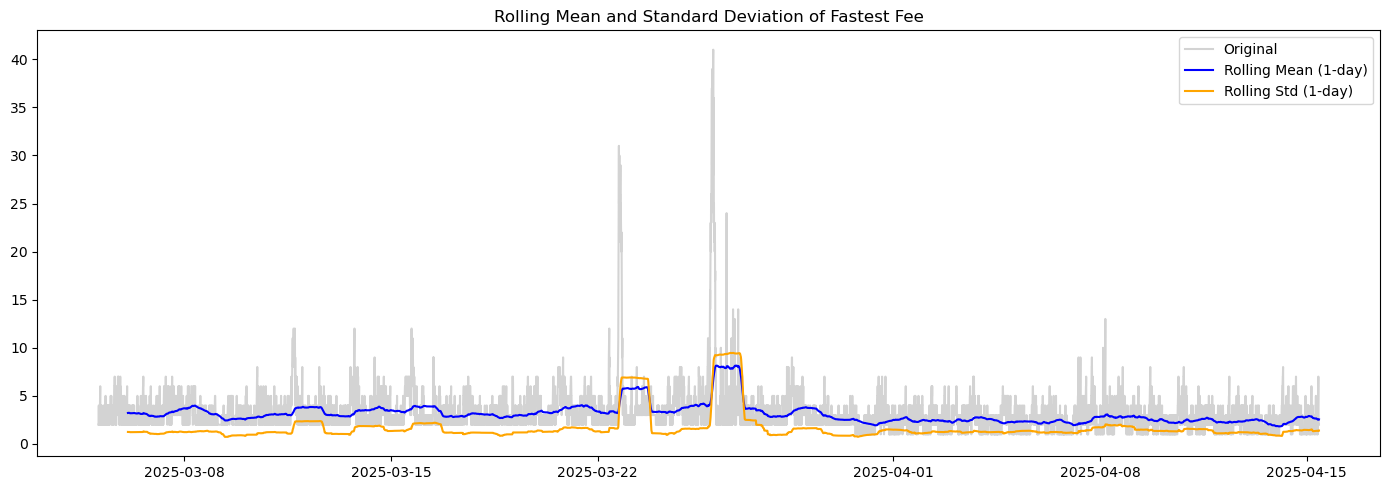

In [21]:
window = 288  # 1-day window for 5-min data

rolling_mean = df["recommended_fee_fastestFee"].rolling(window=window).mean()
rolling_std = df["recommended_fee_fastestFee"].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df["recommended_fee_fastestFee"], color="lightgray", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean (1-day)")
plt.plot(rolling_std, color="orange", label="Rolling Std (1-day)")
plt.title("Rolling Mean and Standard Deviation of Fastest Fee")
plt.legend()
plt.tight_layout()
plt.show()

The plot shows:

- The rolling mean (blue) and rolling standard deviation (orange) exhibit noticeable variation over time.

- There are visible trends and changes in variability, especially around the March 22–24 spike and early April, indicating non-stationarity in both the mean and variance.

#### 8.2 Augmented Dickey-Fuller (ADF) Test

We perform the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the `recommended_fee_fastestFee` series. Understanding whether the series is stationary helps inform the choice of appropriate modeling techniques in subsequent steps.


In [22]:
# Perform ADF test on the target feature
adf_result = adfuller(df["recommended_fee_fastestFee"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -13.202832709143335
p-value: 1.0856781363203985e-24
Critical Value (1%): -3.4309
Critical Value (5%): -2.8618
Critical Value (10%): -2.5669


The ADF test result shows a test statistic of -13.20, which is significantly lower than all critical values at the 1%, 5%, and 10% levels. The p-value is effectively zero (1.08e-24).

This provides strong initial evidence to reject the null hypothesis of non-stationarity, suggesting that the `recommended_fee_fastestFee` series is stationary when considered as a whole.

However, since previous decomposition plots revealed localized spikes and volatility changes, we proceed to validate this assumption at a finer temporal scale in Section 8.3 by testing each week separately.


#### 8.3 Week-by-Week Stationarity Analysis

To capture local variations in stationarity, we split the dataset into weekly segments (2016 rows per week, based on 5-minute intervals). We run the Augmented Dickey-Fuller (ADF) test on each week's data separately. If a particular week is found to be non-stationary (p-value > 0.05), we plan to further split that week into daily chunks and repeat the analysis.

This analysis allows us to detect short-term structural changes or anomalies that may affect model assumptions.

In [31]:
# Create custom week column based on 7-day windows from starting timestamp
start_time = df.index.min()
df['custom_week'] = ((df.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Only keep the first 5 full 7-day blocks
df = df[df['custom_week'] <= 5]

# Run ADF test for each 7-day block
results = []

for week in range(1, 6):
    series = df[df['custom_week'] == week]['recommended_fee_fastestFee'].dropna()
    if len(series) >= 50:
        p_val = adfuller(series)[1]
        results.append({'week': week, 'p_value': p_val})
    else:
        results.append({'week': week, 'p_value': None})

weekly_adf_df = pd.DataFrame(results)
weekly_adf_df['p_value'] = weekly_adf_df['p_value'].apply(lambda x: f"{x:.4e}" if pd.notnull(x) else "NA")
display(weekly_adf_df)

,week,p_value
0,1,5.0183e-10
1,2,4.8604e-10
2,3,6.1720e-09
3,4,1.2239e-05
4,5,4.2756e-09


Each of the five 7-day segments shows a p-value well below all significance thresholds, confirming that the target series is **locally stationary** throughout the dataset.

Combined with the result from Section 8.2, which showed global stationarity across the entire period, we can confidently conclude that the `recommended_fee_fastestFee` series is stable both overall and within short-term windows.

This supports the use of time-series models that assume a stationary input—such as ARIMA, SARIMA, or seasonality-aware machine learning methods—without requiring differencing or structural adjustments.

#### 8.4 ACF and PACF of Target Feature
To determine the most suitable sampling frequency for time series modeling, we evaluate the partial autocorrelation (PACF) structure of the target variable under different resampled intervals: 5min, 10min, 15min, 20min, 30min, and 1h.

For each interval, we compute PACF values up to lag 5 and extract:
- **PACF at lag 1**: Strength of short-term dependency
- **PACF at lag 2**: Used to assess decay speed
- **Decay ratio (lag1 / lag2)**: A higher value indicates clearer short-range structure and better suitability for AR-type models

This comparison guides our selection of an interval that balances signal clarity with temporal resolution.


In [35]:
freqs = ['5min', '10min', '15min', '20min', '30min', '1h']
results = []

for freq in freqs:
    # Resample and drop NA
    resampled = df['recommended_fee_fastestFee'].resample(freq).mean().dropna()

    # Compute PACF up to lag 5
    pacf_vals = pacf(resampled, nlags=5, method='yw')

    # Safety check
    if len(pacf_vals) >= 3:
        lag1 = pacf_vals[1]
        lag2 = pacf_vals[2]
        decay_ratio = lag1 / lag2 if lag2 != 0 else float('inf')

        results.append({
            'frequency': freq,
            'pacf_lag1': round(lag1, 3),
            'pacf_lag2': round(lag2, 3),
            'decay_ratio': round(decay_ratio, 2)
        })

interval_eval_df = pd.DataFrame(results)
display(interval_eval_df.sort_values(by='pacf_lag1', ascending=False))


,frequency,pacf_lag1,pacf_lag2,decay_ratio
0,5min,0.918,0.142,6.48
1,10min,0.905,0.097,9.33
2,15min,0.899,0.045,20.18
3,20min,0.884,0.042,21.02
4,30min,0.866,-0.052,-16.72
5,1h,0.801,-0.364,-2.20


PACF values across different resampled intervals reveal that all short-term frequencies exhibit strong autocorrelation at lag 1, indicating short-term predictability.

The 15-minute and 20-minute intervals stand out with high lag-1 PACF values (≈ 0.89) and extremely rapid decay by lag 2 (≈ 0.04), resulting in decay ratios above 20.  
This suggests that these intervals strike the best balance between signal strength and temporal abstraction.

By contrast, 30-minute and 1-hour intervals show negative PACF values beyond lag 1, indicating over-smoothing and loss of usable structure.

We therefore recommend using a **15-minute or 20-minute interval** for downstream modeling, as they preserve meaningful autocorrelation patterns while reducing short-term noise.

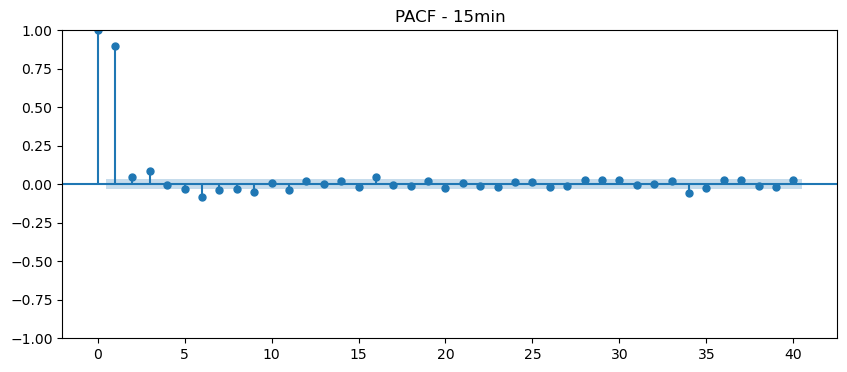

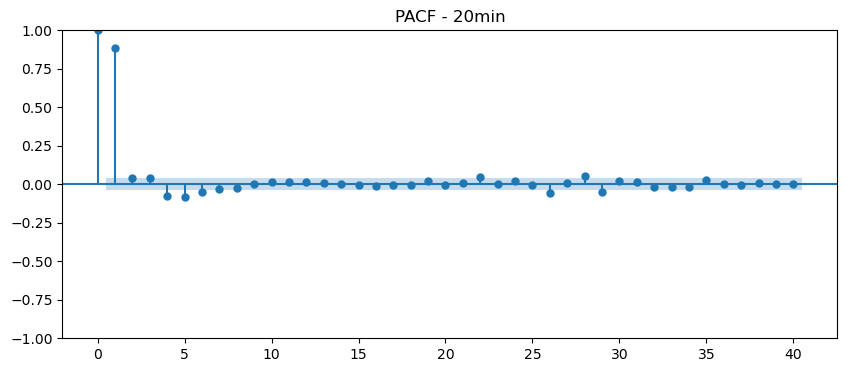

In [36]:
top_freqs = ['15min', '20min']

from statsmodels.graphics.tsaplots import plot_pacf

for freq in top_freqs:
    resampled = df['recommended_fee_fastestFee'].resample(freq).mean().dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    plot_pacf(resampled, lags=40, ax=ax, title=f'PACF - {freq}')
    plt.show()

Based on both PACF statistics and visual inspection of lag structure, the 15-minute interval demonstrates the strongest short-term autocorrelation and the cleanest decay pattern.  
This makes it the most suitable sampling frequency for downstream time series modeling.

We will proceed with 15-minute resampled data in all subsequent analysis and modeling steps.

### 9. Correlation Heatmap

We visualize the correlation among feature groups using heatmaps.

In [ ]:
group_prefixes = {
    # "mempool_blocks": "mempool_blocks_",
    "recommended_fee": "recommended_fee_",
    "mempool": "mempool_",
    "difficulty_adjustment": "difficulty_adjustment_",
    "price": "price_"
}
excluded_prefixes = ["mempool_fee_histogram_"]
def plot_group_correlation(df, group_name, prefix, exclude_prefixes=None):
    # Select columns matching prefix
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # Exclude anything that starts with excluded prefixes
    if exclude_prefixes:
        group_cols = [col for col in group_cols if not any(col.startswith(ex) for ex in exclude_prefixes)]

    # Drop NA for correlation
    group_df = df[group_cols].dropna()

    # Skip if not enough features
    if len(group_cols) < 2:
        print(f"Skipping group '{group_name}' — fewer than 2 valid columns.")
        return

    # Compute correlation
    corr = group_df.corr()

    # Shorten columns that start with 'difficulty_adjustment_' to 'diff_adj_'
    corr.columns = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.columns]
    corr.index = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.index]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
    plt.title(f"{group_name} Feature Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


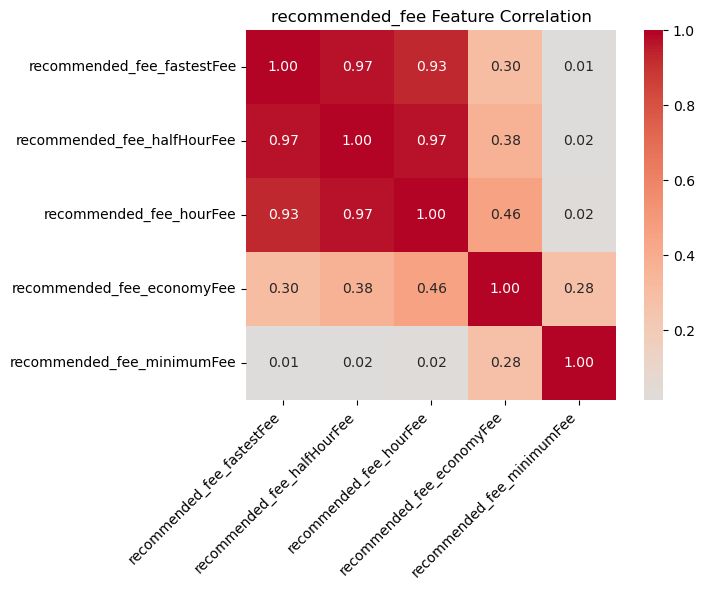

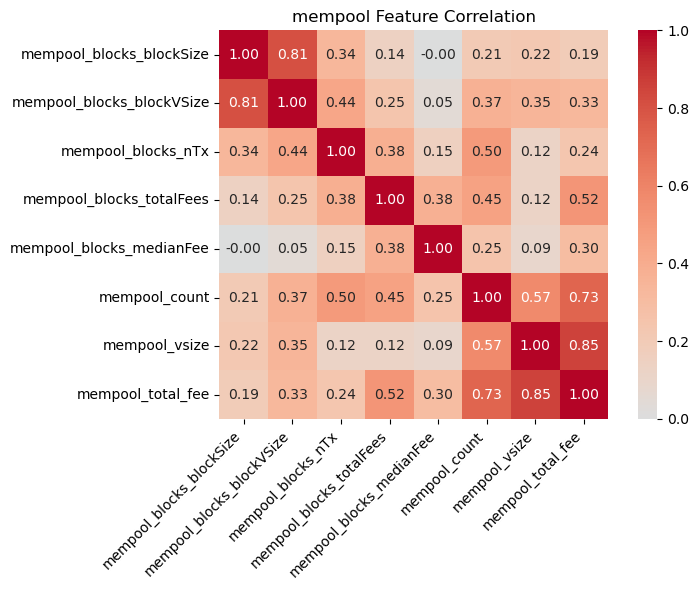

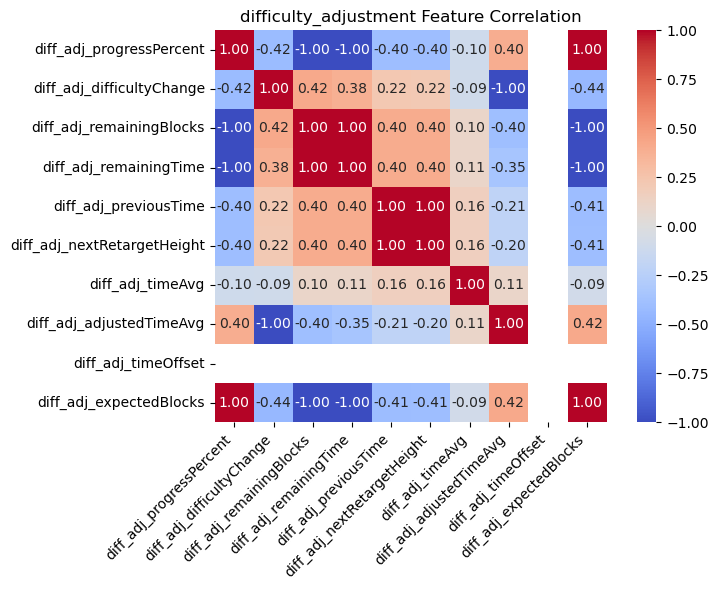

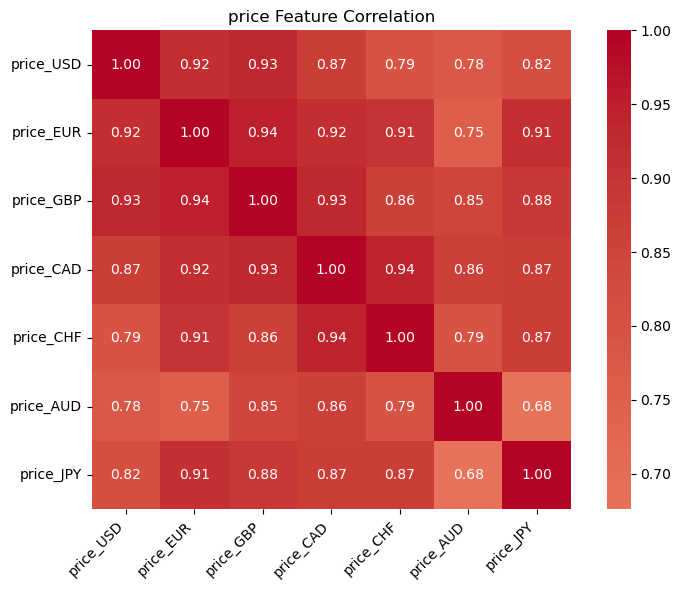

In [ ]:
for group_name, prefix in group_prefixes.items():
    plot_group_correlation(df, group_name, prefix, exclude_prefixes = excluded_prefixes)


The correlation heatmaps reveal several important relationships:

- Recommended fees like `fastestFee`, `halfHourFee`, and `hourFee` are highly correlated (ρ > 0.9), suggesting they track similar market dynamics.

- Mempool size and total fee (`mempool_vsize`, `mempool_total_fee`) are strongly correlated, while `medianFee` is weakly correlated with most other variables.

- Difficulty adjustment features include many exact or inverse relationships, reflecting the internal mechanics of Bitcoin's difficulty retargeting.

- BTC prices across currencies are also highly correlated due to stable exchange rates.

These insights help us identify potential multicollinearity, guide feature selection, and motivate dimensionality reduction if needed.

In [ ]:
df.columns.tolist()

['mempool_blocks_blockSize',
 'mempool_blocks_blockVSize',
 'mempool_blocks_nTx',
 'mempool_blocks_totalFees',
 'mempool_blocks_medianFee',
 'recommended_fee_fastestFee',
 'recommended_fee_halfHourFee',
 'recommended_fee_hourFee',
 'recommended_fee_economyFee',
 'recommended_fee_minimumFee',
 'mempool_count',
 'mempool_vsize',
 'mempool_total_fee',
 'difficulty_adjustment_progressPercent',
 'difficulty_adjustment_difficultyChange',
 'difficulty_adjustment_remainingBlocks',
 'difficulty_adjustment_remainingTime',
 'difficulty_adjustment_previousTime',
 'difficulty_adjustment_nextRetargetHeight',
 'difficulty_adjustment_timeAvg',
 'difficulty_adjustment_adjustedTimeAvg',
 'difficulty_adjustment_timeOffset',
 'difficulty_adjustment_expectedBlocks',
 'price_USD',
 'price_EUR',
 'price_GBP',
 'price_CAD',
 'price_CHF',
 'price_AUD',
 'price_JPY',
 'mempool_fee_histogram_bin_1_2',
 'mempool_fee_histogram_bin_2_3',
 'mempool_fee_histogram_bin_3_4',
 'mempool_fee_histogram_bin_4_5',
 'mempool_

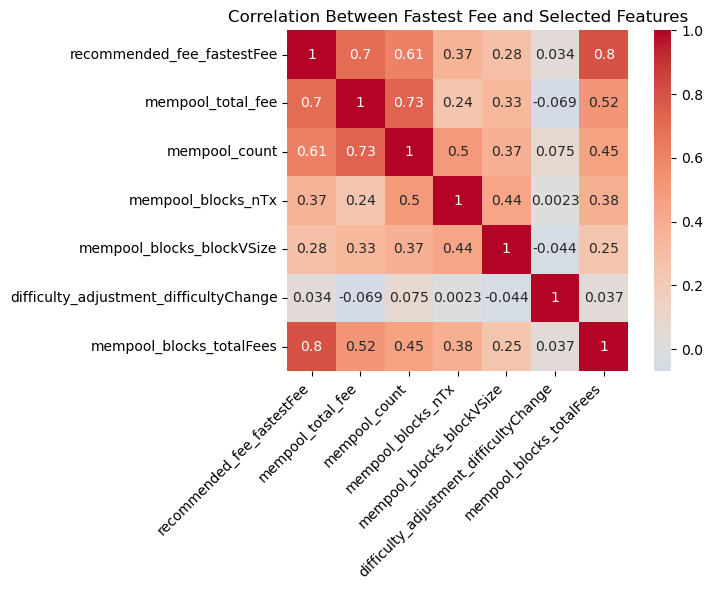

In [ ]:
corr_features = [
    "recommended_fee_fastestFee",        
    "mempool_total_fee",
    "mempool_count",
    "mempool_blocks_nTx",
    "mempool_blocks_blockVSize",
    "difficulty_adjustment_difficultyChange",
    "mempool_blocks_totalFees"
]

# Correlation matrix
corr_matrix = df[corr_features].dropna().corr()

# Plot full square heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Between Fastest Fee and Selected Features")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


We examined the correlation between `fastestFee` and a curated set of external features across mempool, block, and difficulty adjustment domains.

Key findings:
- `mempool_blocks_totalFees` (0.80), `mempool_total_fee` (0.70), and `mempool_count` (0.61) show strong positive correlation, confirming fee pressure rises with mempool congestion.
- `mempool_blocks_nTx` (0.37) and `blockVSize` (0.28) reflect block utilization and throughput.
- `difficulty_adjustment_difficultyChange` shows minimal correlation (0.03) and is included for completeness as a structural variable.

These features were selected to support the design of multivariate models like XGBoost, providing meaningful external signals beyond simple autoregressive terms.

### 10. Key features

#### 10.1 Summary Table of Selected Features

Since our goal is to forecast fee rates, the key features should be those that are:

1. Directly Related to Fee Behavior
Influence how fees are set or how congestion builds up
Reflect network load or transaction priority dynamics
2. Useful for Forecasting Time Series
Time-varying
Available in real-time or known into the future

| Category                | Features                                                                                      | Why Important?                                                                                      |
|-------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| Target & Fee Estimates  | `recommended_fee_fastestFee`, `recommended_fee_halfHourFee`, `recommended_fee_hourFee`, `recommended_fee_economyFee`, `recommended_fee_minimumFee` | These are the predicted targets (or close variants), and how the mempool system estimates current rates |
| Mempool Congestion      | `mempool_count`, `mempool_vsize`, `mempool_total_fee`                                        | Reflect the real-time network load and pending demand                                              |
| Block Characteristics   | `mempool_blocks_blockSize`, `mempool_blocks_blockVSize`, `mempool_blocks_nTx`, `mempool_blocks_totalFees`, `mempool_blocks_medianFee` | Describe current mining block shape and behavior                                                  |
| Difficulty Signals      | `difficulty_adjustment_remainingBlocks`, `difficulty_adjustment_difficultyChange`, `difficulty_adjustment_adjustedTimeAvg` | Affect block production pace and expected fee demand                                              |
| Market Prices           | `price_USD`, `price_CAD`, `price_EUR`, etc.                                                   | May capture global market sentiment and volume, though likely weak correlates unless fees are fiat-tied |



#### 10.2 Distributions of Selected Features

We visualize the distribution of selected key features to assess skewness, potential outliers, and feature variability. This helps determine if any transformation (e.g., log) may be beneficial before modeling.

In [ ]:
key_features = [
    # fee estimates
    "recommended_fee_fastestFee",
    "recommended_fee_halfHourFee",
    "recommended_fee_hourFee",
    "recommended_fee_economyFee",
    "recommended_fee_minimumFee",
    
    # mempool state
    "mempool_count",
    "mempool_vsize",
    "mempool_total_fee",
    
    # block metrics
    "mempool_blocks_blockSize",
    "mempool_blocks_blockVSize",
    "mempool_blocks_nTx",
    "mempool_blocks_totalFees",
    "mempool_blocks_medianFee",
    
    # difficulty signals (select most relevant)
    "difficulty_adjustment_remainingBlocks",
    "difficulty_adjustment_difficultyChange",
    "difficulty_adjustment_adjustedTimeAvg",
    
    # market signal 
    "price_USD"
]


In [ ]:
def plot_distributions(columns, cols_per_row=3):
    rows = int(np.ceil(len(columns) / cols_per_row))
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color="cornflowerblue")
        axes[i].set_title(col, fontsize=11)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Key Feature Distributions (excluding histogram bins)", fontsize=16)
    fig.tight_layout()
    plt.show()

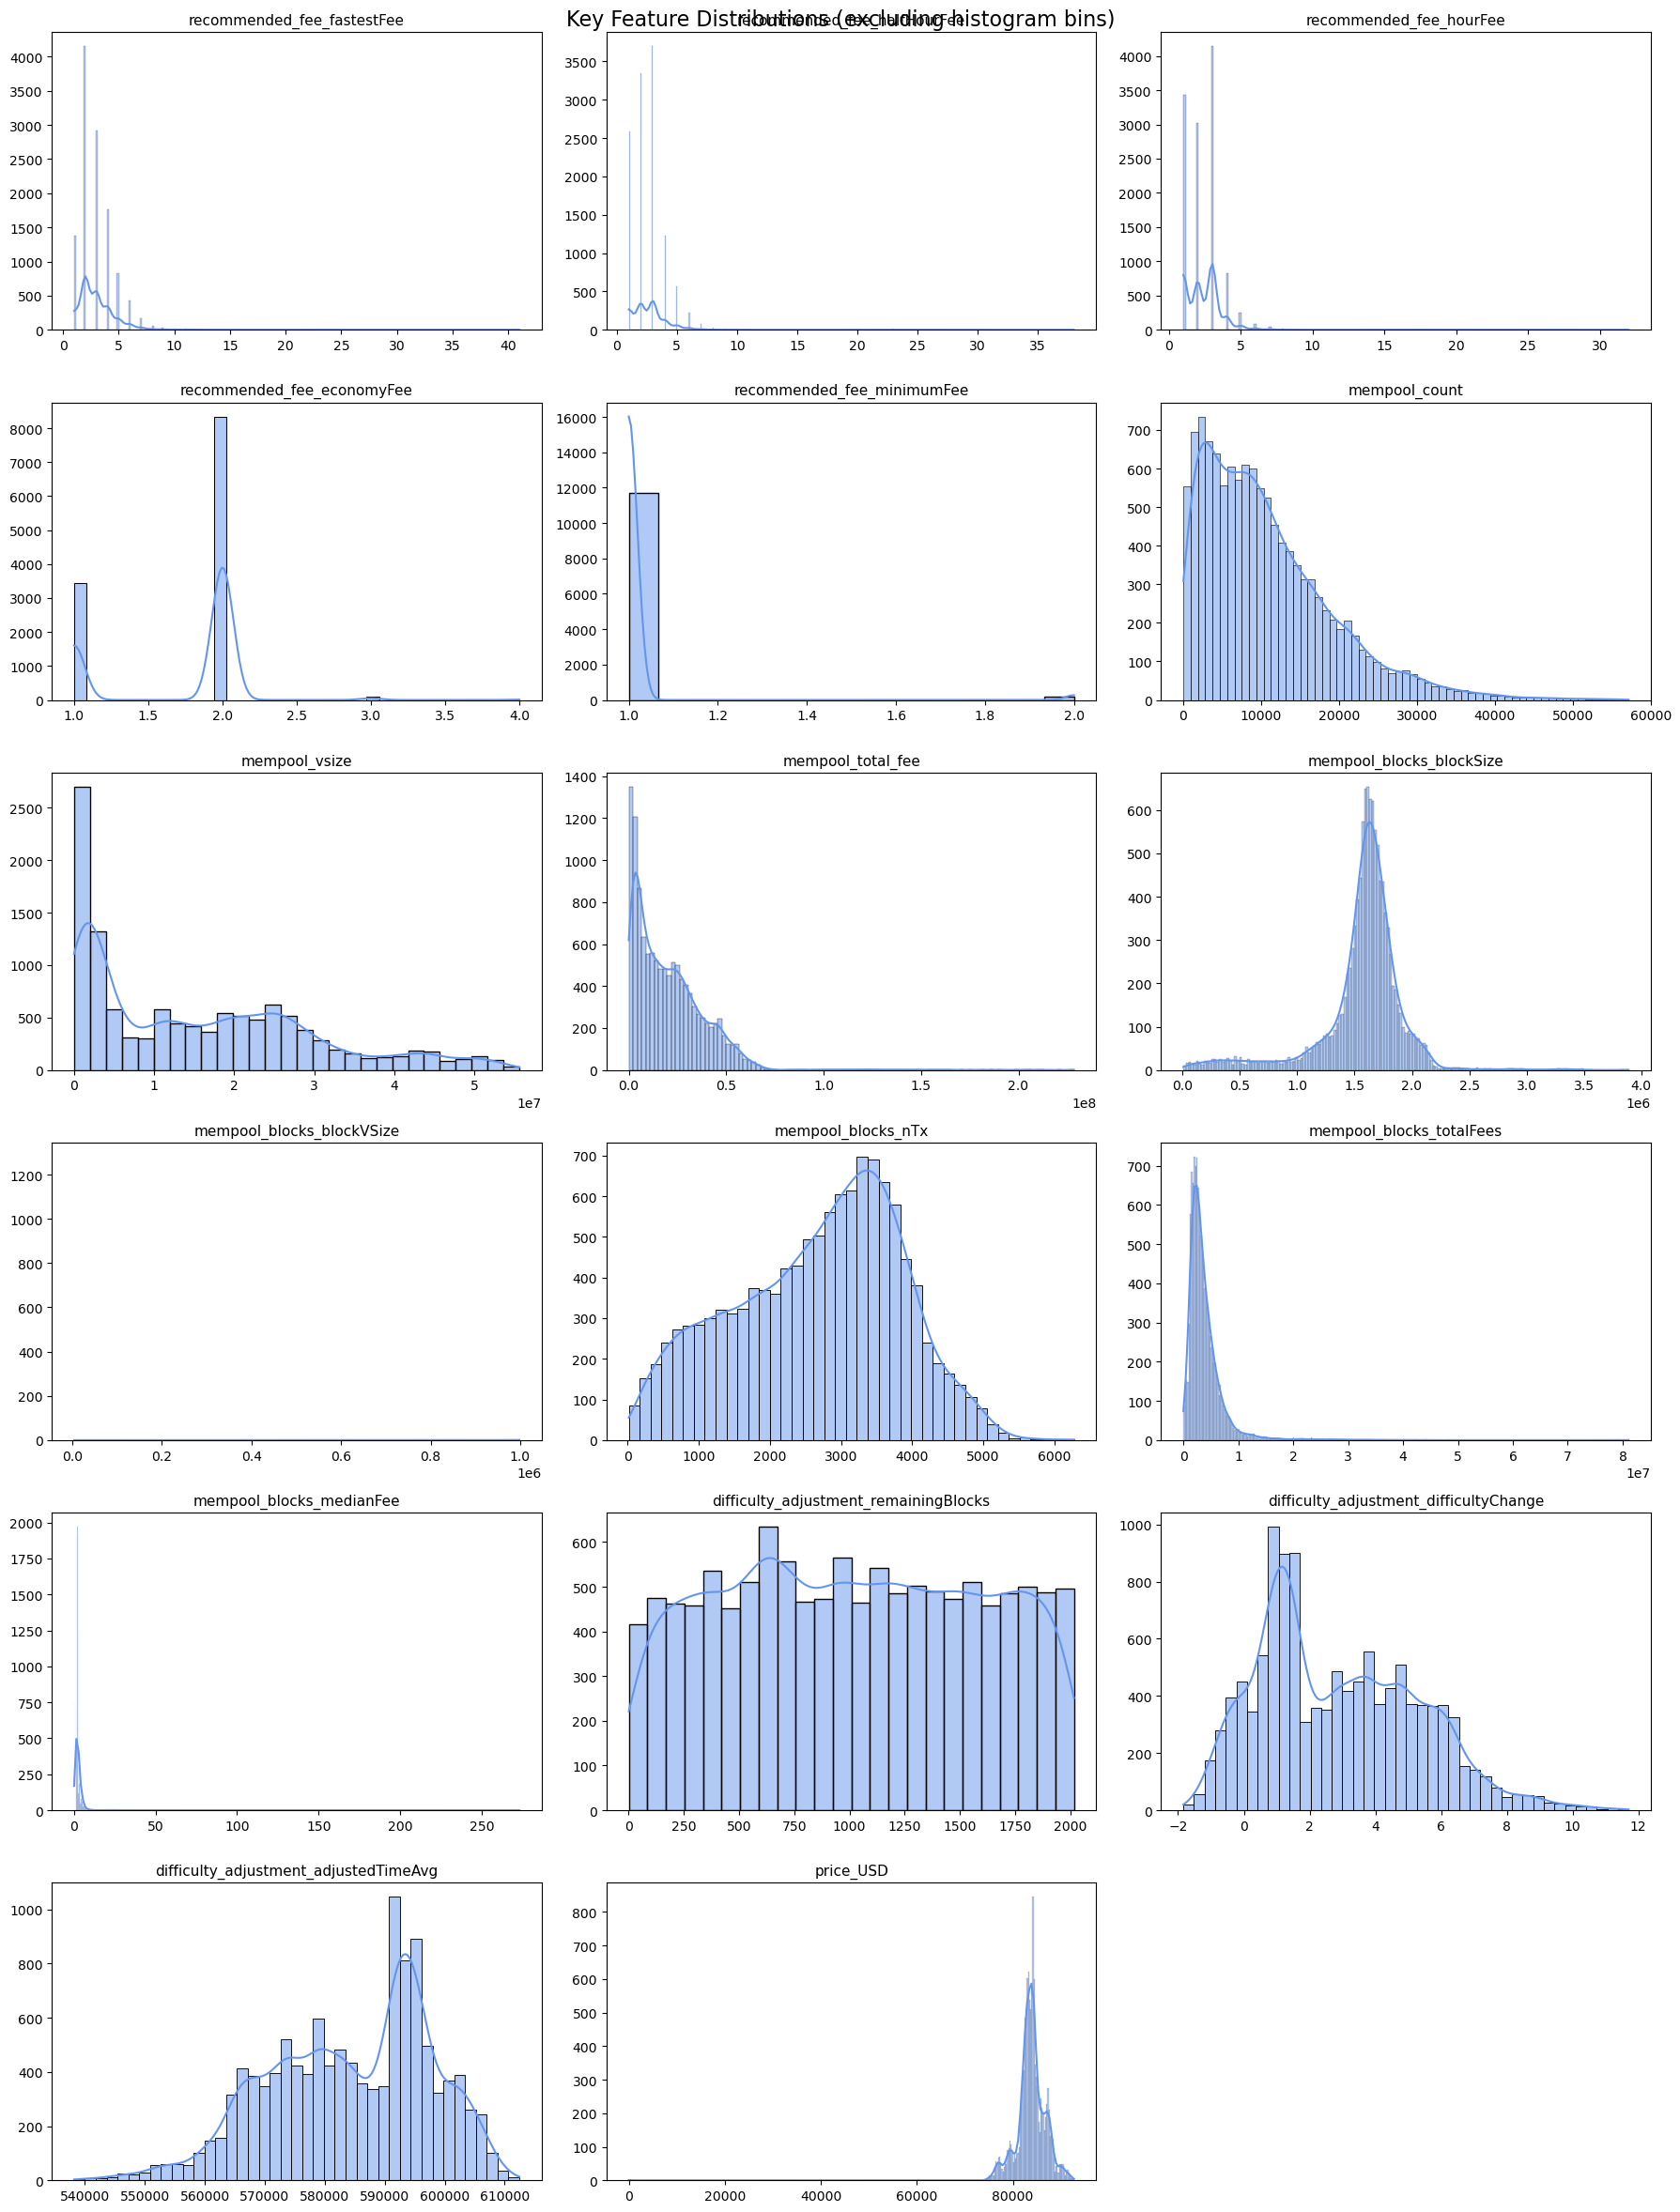

In [ ]:
plot_distributions(key_features)


This section identifies the most relevant features for forecasting transaction fee rates. These include direct fee estimates, mempool congestion indicators, mining block characteristics, difficulty adjustment signals, and market prices.
The visual inspection shows that many of these features are highly skewed (e.g., `recommended_fee_fastestFee`, `mempool_total_fee`), suggesting the potential need for transformation (e.g., log-scaling) in modeling.
This curated set of features will guide the baseline and advanced forecasting models in subsequent stages.

### 11. Model Selection Justification Based on EDA

To guide model development, we summarize the key findings from our exploratory data analysis and use them to motivate the choice of forecasting models.

#### Key Observations from EDA:

- **Stationarity:** ADF tests show that the target variable `fastestFee` is stationary, meaning differencing is not necessary for traditional time series models like ARIMA.
- **Seasonality:** Daily patterns are present (288 points per day with 5-minute intervals), as shown in seasonal decomposition. Weekly patterns may also be relevant.
- **Volatility:** The target shows sharp spikes and irregular fluctuations, making it challenging for simple linear models to capture.
- **Correlations:** Several features (e.g., mempool size, number of transactions, recommended fees) show strong correlation with `fastestFee`.
- **Multivariate context:** We have access to multiple related signals (mempool metrics, block statistics, price), suggesting the potential benefit of multivariate models.

---

#### Model Strategy:

Based on these findings, we proceed with a two-stage modeling strategy:

1. **Baseline Models**
   - **ARIMA / SARIMA:** Suitable for univariate stationary series with autocorrelation and seasonality.
   - **HWES (Holt-Winters Exponential Smoothing):** Captures trend and seasonality with minimal configuration.
   - **XGBoost:** Tree-based regression that handles lag features and multiple inputs well, especially for capturing nonlinear effects.

2. **Advanced Models**
   - **Prophet:** Decomposes the series into trend and seasonality, robust to missing intervals and interpretable.
   - **DeepAR:** An RNN-based model designed for forecasting with complex, nonlinear patterns across time.
   - **Temporal Fusion Transformer (TFT):** The most powerful model in our pipeline, leveraging attention mechanisms and variable selection to learn from multivariate, temporal data.

---

This modeling plan allows us to:
- Compare statistical models and machine learning methods;
- Assess the impact of seasonality and external features;
- Build toward high-performance and interpretable forecasting tools.

### EDA Summary

#### 1. Distributional Analysis
- The target variable `fastestFee` is highly skewed and volatile, with frequent spikes during network congestion.
- Log transformation was applied to fee bin counts to handle skewness and long-tail distributions.
- Features such as `mempool_transactions`, `block_interval`, and `price_usd_diff_1h` show long tails and benefit from scaling or transformation.
- Correlation analysis revealed strong relationships between `fastestFee` and features like `mempool_weight`, `mempool_transactions`, `hourFee`, and `block_interval`.

#### 2. Seasonality and Trend
- Clear daily seasonality is present in the data (288 points per day with 5-minute intervals), with higher fee activity during daytime hours.
- Weekly patterns may also exist and could enhance model performance if incorporated.
- Both additive and multiplicative decompositions confirm strong intra-day cycles.

#### 3. Stationarity Checks
- The ADF test confirms that the target variable is stationary, so differencing is not required for ARIMA-type models.
- Rolling mean and standard deviation plots suggest overall stability of the series.
- ACF and PACF plots indicate that `fastestFee` exhibits autocorrelation, resembling an AR(2) process.

#### 4. Modeling Preparation
- A set of key features were selected across four domains: fee estimates, mempool metrics, block statistics, and market price signals.
- Lag features are justified based on observed autocorrelation in `fastestFee`.
- The data structure supports both univariate time series models (e.g., ARIMA, HWES) and multivariate models (e.g., XGBoost, DeepAR, TFT).
